# CFP Propensity Version 1.0

### LIBRARY IMPORTS

In [1]:
'''Importing Required Libraries'''
import copy
from collections import OrderedDict
import pandas as pd
import lightgbm as lgb
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier,SGDRegressor
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
import joblib

### DATA IMPORT

In [2]:
'''Importing the data for modelling'''
# cfp_data = pd.read_csv(r"D:\Dbeaver Out\CFP_Green_data_2211to2301_202304201536.csv", na_values=['',' ','NH', 'NA', '[]'], low_memory=False)
cfp_data = pd.read_csv(r"D:\Dbeaver Out\CFP_Red_data_2211to2301_202304201538.csv", na_values=['',' ','NH', 'NA', '[]'], low_memory=False)

In [3]:
cfp_data.drop(['reff_88','reff_07', 'ref_390', 'ref_prod_disb'],axis=1,inplace=True) 

In [4]:
cfp_data.columns

Index(['user_id', 'ltd', 'customer_type', 'nsaleable', 'latest_login_date',
       'salary_account', 'cfp_subscribed', 'monthly_income', 'credit_score',
       'age', 'pincode', 'marital_status', 'employment_type',
       'first_profile_date', 'latest_profile_date', 'city_band',
       'ptp_last_three_months_flag', 'positive_response_rate',
       'contactability', 'email_login_flag', 'unique_days_logged_in_flag',
       'sms_login_flag', 'last_login_vintage', 'negative_status_flag',
       'settled_flag', 'open_total_ratio', 'totl_neg_ratio',
       'saleable_accounts_count', 'cfp_interest', 'auto_loan_count',
       'gold_loan_count', 'consumer_loan_count', 'housing_loan_count',
       'credit_card_count', 'personal_loan_count', 'two_wheeler_count',
       'open_accounts', 'open_bank_fintech', 'open_bank_nbfc',
       'closed_accounts', 'settled_accounts', 'written_off_accounts',
       'flows_accounts', 'secured', 'unsecured', 'open_negative_status_count',
       'individual_account

In [5]:
'''Capping'''
cfp_data['age'] = np.where(cfp_data['age']<16,16,cfp_data['age'])
cfp_data['age'] = np.where(cfp_data['age']>42,42,cfp_data['age'])
cfp_data['monthly_income'] = np.where(cfp_data['monthly_income']>33000,33000,cfp_data['monthly_income'])
cfp_data['credit_score'] = np.where(cfp_data['credit_score']>750,750,cfp_data['credit_score'])
cfp_data['auto_loan_count'] = np.where(cfp_data['auto_loan_count']>2,2,cfp_data['auto_loan_count'])
cfp_data['gold_loan_count'] = np.where(cfp_data['gold_loan_count']>9,9,cfp_data['gold_loan_count'])
# cfp_data['consumer_loan_count'] = np.where(cfp_data['consumer_loan_count']>3,3,cfp_data['consumer_loan_count'])
cfp_data['housing_loan_count'] = np.where(cfp_data['housing_loan_count']>1,1,cfp_data['housing_loan_count'])
# cfp_data['credit_card_count'] = np.where(cfp_data['credit_card_count']>4,4,cfp_data['credit_card_count'])
# cfp_data['personal_loan_count'] = np.where(cfp_data['personal_loan_count']>2,2,cfp_data['personal_loan_count'])
cfp_data['two_wheeler_count'] = np.where(cfp_data['two_wheeler_count']>2,2,cfp_data['two_wheeler_count'])
# cfp_data['open_accounts'] = np.where(cfp_data['open_accounts']>7,7,cfp_data['open_accounts'])
cfp_data['open_bank_fintech'] = np.where(cfp_data['open_bank_fintech']>1,1,cfp_data['open_bank_fintech'])
cfp_data['open_bank_nbfc'] = np.where(cfp_data['open_bank_nbfc']>2,2,cfp_data['open_bank_nbfc'])
# cfp_data['closed_accounts'] = np.where(cfp_data['closed_accounts']>5,5,cfp_data['closed_accounts'])
cfp_data['settled_accounts'] = np.where(cfp_data['settled_accounts']>5,5,cfp_data['settled_accounts'])
cfp_data['written_off_accounts'] = np.where(cfp_data['written_off_accounts']>5,5,cfp_data['written_off_accounts'])
cfp_data['flows_accounts'] = np.where(cfp_data['flows_accounts']>5,5,cfp_data['flows_accounts'])
# cfp_data['secured'] = np.where(cfp_data['secured']>1,1,cfp_data['secured'])
# cfp_data['unsecured'] = np.where(cfp_data['unsecured']>1,1,cfp_data['unsecured'])
cfp_data['open_negative_status_count'] = np.where(cfp_data['open_negative_status_count']>5,5,cfp_data['open_negative_status_count'])
cfp_data['individual_account'] = np.where(cfp_data['individual_account']>5,5,cfp_data['individual_account'])
cfp_data['joint_account'] = np.where(cfp_data['joint_account']>5,5,cfp_data['joint_account'])
cfp_data['total_amt_sanctioned'] = np.where(cfp_data['total_amt_sanctioned']>200,200,cfp_data['total_amt_sanctioned'])
cfp_data['total_balance'] = np.where(cfp_data['total_balance']>50,50,cfp_data['total_balance'])
cfp_data['credit_limit'] = np.where(cfp_data['credit_limit']>20,20,cfp_data['credit_limit'])
cfp_data['repayment_tenure'] = np.where(cfp_data['repayment_tenure']>12,12,cfp_data['repayment_tenure'])
cfp_data['total_emi_amount'] = np.where(cfp_data['total_emi_amount']>20000,20000,cfp_data['total_emi_amount'])
cfp_data['hdfc_neg_flag'] = np.where(cfp_data['hdfc_neg_flag']>1,1,cfp_data['hdfc_neg_flag'])
cfp_data['citi_neg_flag'] = np.where(cfp_data['citi_neg_flag']>1,1,cfp_data['citi_neg_flag'])
cfp_data['sbi_neg_flag'] = np.where(cfp_data['sbi_neg_flag']>1,1,cfp_data['sbi_neg_flag'])
cfp_data['icici_neg_flag'] = np.where(cfp_data['icici_neg_flag']>1,1,cfp_data['icici_neg_flag'])
cfp_data['cc_neg_flag'] = np.where(cfp_data['cc_neg_flag']>1,1,cfp_data['cc_neg_flag'])
cfp_data['pl_neg_flag'] = np.where(cfp_data['pl_neg_flag']>1,1,cfp_data['pl_neg_flag'])
cfp_data['cl_neg_flag'] = np.where(cfp_data['cl_neg_flag']>1,1,cfp_data['cl_neg_flag'])
cfp_data['auto_loan_close_count_last3mnths'] = np.where(cfp_data['auto_loan_close_count_last3mnths']>1,1,cfp_data['auto_loan_close_count_last3mnths'])
cfp_data['gold_loan_close_count_last3mnths'] = np.where(cfp_data['gold_loan_close_count_last3mnths']>1,1,cfp_data['gold_loan_close_count_last3mnths'])
cfp_data['consumer_loan_close_count_last3mnths'] = np.where(cfp_data['consumer_loan_close_count_last3mnths']>1,1,cfp_data['consumer_loan_close_count_last3mnths'])
cfp_data['housing_loan_close_count_last3mnths'] = np.where(cfp_data['housing_loan_close_count_last3mnths']>1,1,cfp_data['housing_loan_close_count_last3mnths'])
cfp_data['credit_card_close_count_last3mnths'] = np.where(cfp_data['credit_card_close_count_last3mnths']>1,1,cfp_data['credit_card_close_count_last3mnths'])
cfp_data['personal_loan_close_count_last3mnths'] = np.where(cfp_data['personal_loan_close_count_last3mnths']>1,1,cfp_data['personal_loan_close_count_last3mnths'])
cfp_data['two_wheeler_close_count_last3mnths'] = np.where(cfp_data['two_wheeler_close_count_last3mnths']>1,1,cfp_data['two_wheeler_close_count_last3mnths'])
cfp_data['individual_close_account_last3mnths'] = np.where(cfp_data['individual_close_account_last3mnths']>1,1,cfp_data['individual_close_account_last3mnths'])
cfp_data['closed_accounts_last3mnths'] = np.where(cfp_data['closed_accounts_last3mnths']>1,1,cfp_data['closed_accounts_last3mnths'])
cfp_data['secured_close_last3mnths'] = np.where(cfp_data['secured_close_last3mnths']>1,1,cfp_data['secured_close_last3mnths'])
cfp_data['unsecured_close_last3mnths'] = np.where(cfp_data['unsecured_close_last3mnths']>1,1,cfp_data['unsecured_close_last3mnths'])
cfp_data['negative_status_close_count_last3mnths'] = np.where(cfp_data['negative_status_close_count_last3mnths']>1,1,cfp_data['negative_status_close_count_last3mnths'])
cfp_data['joint_account_close_last3mnths'] = np.where(cfp_data['joint_account_close_last3mnths']>1,1,cfp_data['joint_account_close_last3mnths'])
cfp_data['max_score'] = np.where(cfp_data['max_score']>750,750,cfp_data['max_score'])
cfp_data['score_on_m9'] = np.where(cfp_data['score_on_m9']>750,750,cfp_data['score_on_m9'])
cfp_data['score_on_m3'] = np.where(cfp_data['score_on_m3']>750,750,cfp_data['score_on_m3'])
cfp_data['score_on_m12'] = np.where(cfp_data['score_on_m12']>750,750,cfp_data['score_on_m12'])
cfp_data['score_on_m6'] = np.where(cfp_data['score_on_m6']>750,750,cfp_data['score_on_m6'])
cfp_data['neg_acc_on_m9'] = np.where(cfp_data['neg_acc_on_m9']>6,6,cfp_data['neg_acc_on_m9'])
cfp_data['neg_acc_on_m3'] = np.where(cfp_data['neg_acc_on_m3']>6,6,cfp_data['neg_acc_on_m3'])
cfp_data['neg_acc_on_m12'] = np.where(cfp_data['neg_acc_on_m12']>6,6,cfp_data['neg_acc_on_m12'])
cfp_data['neg_acc_on_m6'] = np.where(cfp_data['neg_acc_on_m6']>6,6,cfp_data['neg_acc_on_m6'])
# cfp_data['reff_88'] = np.where(cfp_data['reff_88']>2,2,cfp_data['reff_88'])
# cfp_data['reff_07'] = np.where(cfp_data['reff_07']>2,2,cfp_data['reff_07'])
# cfp_data['ref_390'] = np.where(cfp_data['ref_390']>1,1,cfp_data['ref_390'])
# cfp_data['ref_prod_disb'] = np.where(cfp_data['ref_prod_disb']>4,4,cfp_data['ref_prod_disb'])

## PRE-PROCESSING

#### Handling Null Values

In [6]:
''' Replacing with 0s and Harcoded Values'''
cfp_data.ptp_last_three_months_flag.fillna(0, inplace= True)
cfp_data.totl_neg_ratio.fillna(0, inplace= True)
cfp_data.max_score.fillna(cfp_data.max_score.mean(),inplace=True)
cfp_data.auto_loan_close_count_last3mnths.fillna(0, inplace= True)
cfp_data.gold_loan_close_count_last3mnths.fillna(0, inplace= True)
cfp_data.consumer_loan_close_count_last3mnths.fillna(0, inplace= True)
cfp_data.housing_loan_close_count_last3mnths.fillna(0, inplace= True)
cfp_data.credit_card_close_count_last3mnths.fillna(0, inplace= True)
cfp_data.personal_loan_close_count_last3mnths.fillna(0, inplace= True)
cfp_data.two_wheeler_close_count_last3mnths.fillna(0, inplace= True)
cfp_data.individual_close_account_last3mnths.fillna(0, inplace= True)
cfp_data.secured_close_last3mnths.fillna(0, inplace= True)
cfp_data.closed_accounts_last3mnths.fillna(0, inplace= True)
cfp_data.negative_status_close_count_last3mnths.fillna(0, inplace= True)
cfp_data.joint_account_close_last3mnths.fillna(0, inplace= True)
cfp_data.unsecured_close_last3mnths.fillna(0, inplace= True)

cfp_data.auto_loan_count.fillna(0, inplace= True)
cfp_data.gold_loan_count.fillna(0, inplace= True)

cfp_data.housing_loan_count.fillna(0, inplace= True)
cfp_data.credit_card_count.fillna(0, inplace= True)
cfp_data.personal_loan_count.fillna(0, inplace= True)
cfp_data.consumer_loan_count.fillna(0, inplace= True)
cfp_data.two_wheeler_count.fillna(0, inplace= True)
cfp_data.individual_account.fillna(0, inplace= True)
cfp_data.open_accounts.fillna(0, inplace= True)
cfp_data.settled_accounts.fillna(0, inplace= True)
cfp_data.secured.fillna(0, inplace= True)
cfp_data.unsecured.fillna(0, inplace= True)
cfp_data.open_negative_status_count.fillna(0, inplace= True)
cfp_data.joint_account.fillna(0, inplace= True)
cfp_data.total_balance.fillna(0, inplace= True)
cfp_data.written_off_accounts.fillna(0, inplace= True)
cfp_data.flows_accounts.fillna(0, inplace= True)
cfp_data.open_accounts.fillna(0, inplace= True)
cfp_data.closed_accounts.fillna(0, inplace= True)


cfp_data.hdfc_neg_flag.fillna(0, inplace= True)
cfp_data.citi_neg_flag.fillna(0, inplace= True)
cfp_data.sbi_neg_flag.fillna(0, inplace= True)        
cfp_data.icici_neg_flag.fillna(0, inplace= True)         
cfp_data.cc_neg_flag.fillna(0, inplace= True)       
cfp_data.pl_neg_flag.fillna(0, inplace= True)
cfp_data.cl_neg_flag.fillna(0, inplace= True)

cfp_data.total_balance.fillna(0,inplace=True)
cfp_data.total_emi_amount.fillna(0,inplace=True)
cfp_data.total_amt_sanctioned.fillna(0,inplace=True)

cfp_data.credit_limit.fillna(0, inplace= True)
cfp_data.repayment_tenure.fillna(0, inplace= True)


cfp_data.cfp_interest.fillna(0, inplace= True)

cfp_data.salary_account.fillna('Unknown', inplace=True)

In [7]:
cfp_data.isnull().sum()

user_id                                      0
ltd                                          0
customer_type                                0
nsaleable                                    0
latest_login_date                            0
salary_account                               0
cfp_subscribed                               0
monthly_income                             199
credit_score                                 0
age                                          2
pincode                                      1
marital_status                             791
employment_type                           2477
first_profile_date                           0
latest_profile_date                          0
city_band                                    0
ptp_last_three_months_flag                   0
positive_response_rate                       0
contactability                               0
email_login_flag                             0
unique_days_logged_in_flag                   0
sms_login_fla

In [8]:
'''Replacing based on median'''
median_marriage_age=36
def marital_na_filler(marital_status, age): 
    try: 
        if np.isnan(marital_status): 
            if age >= median_marriage_age: 
                return 'Married' 
            else: 
                return 'Single' 
        else: 
            return (marital_status) 
    except: 
        return (marital_status)
cfp_data.marital_status = cfp_data.apply(lambda x: marital_na_filler(x.marital_status, x.age), axis = 1)
cfp_data.monthly_income.fillna(40000, inplace= True)
cfp_data.score_on_m9.fillna(650, inplace= True)
cfp_data.score_on_m3.fillna(650, inplace= True)
cfp_data.score_on_m12.fillna(650, inplace= True)
cfp_data.score_on_m6.fillna(650, inplace= True)
cfp_data.neg_acc_on_m9.fillna(1, inplace= True)
cfp_data.neg_acc_on_m3.fillna(1, inplace= True)
cfp_data.neg_acc_on_m12.fillna(1, inplace= True)
cfp_data.neg_acc_on_m6.fillna(1, inplace= True)
cfp_data.max_dpd_on_m9.fillna(0, inplace= True)
cfp_data.max_dpd_on_m3.fillna(0, inplace= True)
cfp_data.max_dpd_on_m12.fillna(0, inplace= True)
cfp_data.max_dpd_on_m6.fillna(0, inplace= True)
cfp_data.age.fillna(32, inplace= True)

In [9]:
''' Replacing FLAG in city_band with 'Missing/Others' '''
cfp_data.city_band = cfp_data.city_band.apply(lambda x: 'Missing/Others' if x == 'FLAG' else x)

In [10]:
'''Combining Score Params'''
def score_track(credit_score,score_on_m3,score_on_m6,score_on_m9):
    try:
        if (credit_score < score_on_m3):
            return 'Last 3 mths declining'
        if (credit_score <= score_on_m3) & (score_on_m3 > score_on_m6) & (score_on_m6 <= score_on_m9):
            return 'Last 6 mths declining'
        if (credit_score <= score_on_m3) & (score_on_m3 <= score_on_m6):
            return 'Last 6 mths declining'
        if (credit_score <= score_on_m3) & (score_on_m3 <= score_on_m6) & (score_on_m6 <= score_on_m9):
            return 'Last 9 mths declining'      
        if (credit_score > score_on_m3): 
            return 'Last 3 mths Score improving'
    except:
        return 'Score Inconsistent'
    
cfp_data['score_track'] = cfp_data.apply(lambda x: score_track(x['credit_score'] ,x['score_on_m3'] ,x['score_on_m6'],x['score_on_m9']) , axis = 1)

In [11]:
'''Combining Neg Acc Params'''
def neg_acc_track(neg_acc_on_m3,neg_acc_on_m6,neg_acc_on_m9,neg_acc_on_m12):
    try:
        if (neg_acc_on_m3 >= neg_acc_on_m6):
            return 'Last 6 mths increasing'
        if (neg_acc_on_m3 >= neg_acc_on_m6) & (neg_acc_on_m6 >= neg_acc_on_m9):
            return 'Last 9 mths increasing'
        if (neg_acc_on_m3 >= neg_acc_on_m6) & (neg_acc_on_m6 >= neg_acc_on_m9) & (neg_acc_on_m6 >= neg_acc_on_m12):
            return 'Last 12 mths increasing'
    except:
        return 'Neg acc Inconsistent'
    
cfp_data['neg_acc_track'] = cfp_data.apply(lambda x: neg_acc_track(x['neg_acc_on_m3'] ,x['neg_acc_on_m6'] ,x['neg_acc_on_m9'],x['neg_acc_on_m12']) , axis = 1)

In [12]:
'''Combining DPD Params'''
def max_dpd_track(max_dpd_on_m3,max_dpd_on_m6,max_dpd_on_m9,max_dpd_on_m12):
    try:
        if (max_dpd_on_m3 >= max_dpd_on_m6):
            return 'Last 6 mths increasing'
        if (max_dpd_on_m3 >= max_dpd_on_m6) & (max_dpd_on_m6 >= max_dpd_on_m9):
            return 'Last 9 mths increasing'
        if (max_dpd_on_m3 >= max_dpd_on_m6) & (max_dpd_on_m6 >= max_dpd_on_m9) & (max_dpd_on_m6 >= max_dpd_on_m9):
            return 'Last 12 mths increasing'
    except:
        return 'Neg acc Inconsistent'
    
cfp_data['max_dpd_track'] = cfp_data.apply(lambda x: max_dpd_track(x['max_dpd_on_m3'] ,x['max_dpd_on_m6'] ,x['max_dpd_on_m9'],x['max_dpd_on_m12']) , axis = 1)

In [13]:
''' Open_accounts_flag '''
def open_accounts_flag(open_accounts):
    try:
        if open_accounts == 0:
            return 'Zero'
        elif open_accounts == 1:
            return 'One'
        elif open_accounts == 2:
            return 'Two'
        elif open_accounts == 3:
            return 'Three'
        elif open_accounts == 4:
            return 'Four'
        elif open_accounts == 5:
            return 'Five'
        else:
            return 'MoreThanFive'
    except:
        return 'Flag'

cfp_data['open_accounts_cat'] = cfp_data['open_accounts'].apply(lambda x: open_accounts_flag(x))

In [14]:
''' close_accounts_flag '''
def closed_accounts_flag(closed_accounts):
    try:
        if closed_accounts == 0:
            return 'Zero'
        elif closed_accounts == 1:
            return 'One'
        elif closed_accounts == 2:
            return 'Two'
        elif closed_accounts == 3:
            return 'Three'
        elif closed_accounts == 4:
            return 'Four'
        elif closed_accounts == 5:
            return 'Five'
        else:
            return 'MoreThanFive'
    except:
        return 'Flag'
cfp_data['closed_accounts_cat'] = cfp_data['closed_accounts'].apply(lambda x: closed_accounts_flag(x))

In [15]:
''' credit_card_flag '''
def credit_card_flag(credit_card_count):
    try:
        if credit_card_count == 0:
            return 'Zero'
        elif credit_card_count == 1:
            return 'One'
        elif credit_card_count == 2:
            return 'Two'
        elif credit_card_count == 3:
            return 'Three'
        elif credit_card_count == 4:
            return 'Four'
        elif credit_card_count == 5:
            return 'Five'
        else:
            return 'MoreThanFive'
    except:
        return 'Flag'
cfp_data['credit_card_cat'] = cfp_data['credit_card_count'].apply(lambda x: credit_card_flag(x))    

In [16]:
''' personal_loan_flag '''
def personal_loan_flag(personal_loan_count):
    try:
        if personal_loan_count == 0:
            return 'Zero'
        elif personal_loan_count == 1:
            return 'One'
        else:
            return 'MoreThanOne'
    except:
        return 'Flag'
cfp_data['personal_loan_cat'] = cfp_data['personal_loan_count'].apply(lambda x: personal_loan_flag(x))   

In [17]:
''' consumer_loan_flag '''
def consumer_loan_flag(consumer_loan_count):
    try:
        if consumer_loan_count == 0:
            return 'Zero'
        elif consumer_loan_count == 1:
            return 'One'
        elif consumer_loan_count == 2:
            return 'Two'
        else:
            return 'MoreThanTwo'
    except:
        return 'Flag'
cfp_data['consumer_loan_cat'] = cfp_data['consumer_loan_count'].apply(lambda x: consumer_loan_flag(x))   

In [18]:
''' secured_accounts_flag '''
def secured_accounts_flag(secured):
    try:
        if secured == 0:
            return 'Zero'
        elif secured == 1:
            return 'One'
        elif secured == 2:
            return 'Two'
        elif secured == 3:
            return 'Three'
        elif secured == 4:
            return 'Four'
        elif secured == 5:
            return 'Five'
        else:
            return 'MoreThanFive'
    except:
        return 'Flag'
cfp_data['secured_accounts_cat'] = cfp_data['secured'].apply(lambda x: secured_accounts_flag(x))

In [19]:
''' unsecured_accounts_flag '''
def unsecured_accounts_flag(unsecured):
    try:
        if unsecured == 0:
            return 'Zero'
        elif unsecured == 1:
            return 'One'
        elif unsecured == 2:
            return 'Two'
        elif unsecured == 3:
            return 'Three'
        elif unsecured == 4:
            return 'Four'
        elif unsecured == 5:
            return 'Five'
        elif unsecured == 6:
            return 'Six'
        elif unsecured == 7:
            return 'Seven'
        elif unsecured == 8:
            return 'Eight'
        elif unsecured == 9:
            return 'Nine'
        elif unsecured == 10:
            return 'Ten'
        else:
            return 'MoreThanTen'
    except:
        return 'Flag'
cfp_data['unsecured_accounts_cat'] = cfp_data['unsecured'].apply(lambda x: unsecured_accounts_flag(x))

In [20]:
# ''' Dropping the columns that we changed above '''
# drops = ['score_on_m9',
#        'score_on_m3', 'score_on_m12', 'score_on_m6',
#        'neg_acc_on_m9', 'neg_acc_on_m3', 'neg_acc_on_m12',
#         'max_dpd_on_m9', 'max_dpd_on_m3',
#        'max_dpd_on_m12', 'max_dpd_on_m6',  
#        'neg_acc_on_m6','secured','unsecured','open_accounts','closed_accounts',
#         'credit_card_count','personal_loan_count','consumer_loan_count']
# cfp_data.drop(drops, axis = 1, inplace = True)

In [21]:
'''Login Vintage'''
def getFormattedLoginVintage(Login):
    try:
        if Login == 'M1toM2':
            return 3
        elif Login == 'M3toM6':
            return 2
        elif Login == 'M7toM12':
            return 1
        elif Login == 'BeyondM12':
            return 0
    except:
        return 0
cfp_data.last_login_vintage = cfp_data.last_login_vintage.apply(lambda x: getFormattedLoginVintage(x))
cfp_data.last_login_vintage.value_counts()

0    4041
2    2254
3    1985
1    1863
Name: last_login_vintage, dtype: int64

In [22]:
'''Replacing Salary Account Bank with Categories'''
def getFormattedSalaryAccount(Bank):
    try:
        formatted_employment_type = ""
        if Bank == "receiveByCashOrCheque":
            return "I receive by cash"
        elif Bank == 'I receive by cash':
            return "I receive by cash"
        elif Bank == 'I receive by cheque':
            return "I receive by cash"
        elif Bank == 'Unknown':
            return "Unknown"
        elif Bank == '':
            return "Unknown"
        else:
            return 'BankAcc'
    except:
        return employment_type
cfp_data.salary_account = cfp_data.salary_account.apply(lambda x: getFormattedSalaryAccount(x))
cfp_data.salary_account.value_counts()

Unknown              9167
BankAcc               969
I receive by cash       7
Name: salary_account, dtype: int64

In [23]:
'''Format Employment and handle null values'''
def getFormattedEmploymentType(employment_type):
    try:
        formatted_employment_type = ""
        salaried_list = ['Salaried','salaried','Salaried Doctor','Working Executive','Student','Salaried doctor', 'salaried', 'salariedDoctor']
        self_employed_list = ['Self Employed', 'Self employed', 'Self employed professional', 'Self-Employed', 'selfemployee', 'selfEmployedProfessional','Self employed business', 'selfEmployedBusiness', 'Self Employed Business']
        if employment_type in salaried_list:
            return "Salaried"
        elif employment_type in self_employed_list:
            return "Self Employed"
        else:
            return 'Salaried'
    except:
        return employment_type
cfp_data.employment_type = cfp_data.employment_type.apply(lambda x: getFormattedEmploymentType(x))

In [24]:
''' Income and Age to positive if negative '''
cfp_data.monthly_income = cfp_data.monthly_income.apply(lambda x: (x * -1) if x < 0 else x)
cfp_data.age = cfp_data.age.apply(lambda x: (x * -1) if x < 0 else x)

In [25]:
cfp_data.isnull().sum()

user_id                                     0
ltd                                         0
customer_type                               0
nsaleable                                   0
latest_login_date                           0
salary_account                              0
cfp_subscribed                              0
monthly_income                              0
credit_score                                0
age                                         0
pincode                                     1
marital_status                              0
employment_type                             0
first_profile_date                          0
latest_profile_date                         0
city_band                                   0
ptp_last_three_months_flag                  0
positive_response_rate                      0
contactability                              0
email_login_flag                            0
unique_days_logged_in_flag                  0
sms_login_flag                    

### Pickling Data

In [26]:
# joblib.dump(cfp_data, 'cfp_clean_data_Green.pkl')
# joblib.dump(cfp_data, 'cfp_clean_data_Red.pkl')
joblib.dump(cfp_data, 'cfp_clean_data_Red_ltd.pkl')
# joblib.dump(cfp_data, 'cfp_clean_data_Green_ltd.pkl')

['cfp_clean_data_Red_ltd.pkl']

In [27]:
# cfp_data=joblib.load('cfp_clean_data_Green.pkl')
# cfp_data=joblib.load('cfp_clean_data_Red.pkl')
cfp_data=joblib.load('cfp_clean_data_Red_ltd.pkl')
# cfp_data=joblib.load('cfp_clean_data_Green_ltd.pkl')

In [28]:
cfp_backup=copy.deepcopy(cfp_data)
cfp_data.drop(['latest_login_date','first_profile_date','latest_profile_date','pincode','customer_type'],axis=1,inplace=True) 

#### Probe and Handle Outliers

In [29]:
exclude=['user_id','cfp_interest','positive_response_rate', 'contactability',
         'ptp_last_three_months_flag','cfp_subscribed', 'ltd', 'nsaleable', 'latest_login_date',
       'salary_account', 'credit_score',
        'pincode', 'marital_status', 'employment_type',
       'first_profile_date', 'latest_profile_date', 'city_band',
       'positive_response_rate', 'email_login_flag', 'unique_days_logged_in_flag',
       'sms_login_flag', 'last_login_vintage', 'negative_status_flag',
       'settled_flag', 'open_total_ratio', 'totl_neg_ratio',
       'saleable_accounts_count', 'cfp_interest', 'auto_loan_count',
       'gold_loan_count', 'housing_loan_count', 'two_wheeler_count',
       'open_bank_fintech', 'open_bank_nbfc', 'settled_accounts',
       'written_off_accounts', 'flows_accounts', 'open_negative_status_count',
       'individual_account', 'joint_account',
       'hdfc_neg_flag', 'citi_neg_flag', 'sbi_neg_flag', 'icici_neg_flag',
       'cc_neg_flag', 'pl_neg_flag', 'cl_neg_flag',
       'auto_loan_close_count_last3mnths', 'gold_loan_close_count_last3mnths',
       'consumer_loan_close_count_last3mnths',
       'housing_loan_close_count_last3mnths',
       'credit_card_close_count_last3mnths',
       'personal_loan_close_count_last3mnths',
       'two_wheeler_close_count_last3mnths',
       'individual_close_account_last3mnths', 'closed_accounts_last3mnths',
       'secured_close_last3mnths', 'unsecured_close_last3mnths',
       'negative_status_close_count_last3mnths',
       'joint_account_close_last3mnths', 'max_score', 'personal_loan_cat',
       'consumer_loan_cat', 'secured_accounts_cat', 'unsecured_accounts_cat'] #,'cfp_subscribed'

In [30]:
numerical_columns=list(cfp_data.select_dtypes(include='number').columns)
for feature in numerical_columns:
    if feature in exclude:
        pass
    else:
        numerical_columns.remove(feature)
print(numerical_columns)

['user_id', 'ltd', 'nsaleable', 'cfp_subscribed', 'credit_score', 'ptp_last_three_months_flag', 'positive_response_rate', 'contactability', 'last_login_vintage', 'settled_flag', 'open_total_ratio', 'totl_neg_ratio', 'saleable_accounts_count', 'cfp_interest', 'auto_loan_count', 'gold_loan_count', 'housing_loan_count', 'personal_loan_count', 'two_wheeler_count', 'open_bank_fintech', 'open_bank_nbfc', 'settled_accounts', 'written_off_accounts', 'flows_accounts', 'unsecured', 'open_negative_status_count', 'individual_account', 'joint_account', 'total_balance', 'repayment_tenure', 'hdfc_neg_flag', 'citi_neg_flag', 'sbi_neg_flag', 'icici_neg_flag', 'cc_neg_flag', 'pl_neg_flag', 'cl_neg_flag', 'auto_loan_close_count_last3mnths', 'gold_loan_close_count_last3mnths', 'consumer_loan_close_count_last3mnths', 'housing_loan_close_count_last3mnths', 'credit_card_close_count_last3mnths', 'personal_loan_close_count_last3mnths', 'two_wheeler_close_count_last3mnths', 'individual_close_account_last3mnths'

In [31]:
'''Finding Skewness'''
skewed=[]
def find_skew(data,numerical_columns):
    skew_list={}
    for feature in numerical_columns:
        try:
            try:
                skew_value=(3*(data[feature].mean()-data[feature].median()))/data[feature].std()
                if ((round(skew_value,2)<-3) or (round(skew_value,2)>3)):
                    skew_list[feature]='Skewwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww'
                    skewed.append(feature)
                else:
                    skew_list[feature]=round(skew_value,2)
            except ZeroDivisionError:
                skew_list[feature]='Skewwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww'
                skewed.append(feature)
        except:
            pass
    return skew_list
skew_list=find_skew(cfp_data,numerical_columns)
skewed

['nsaleable', 'saleable_accounts_count', 'two_wheeler_count']

In [32]:
'''Transforming features - Adjusting for skewness'''
for i in numerical_columns:
    if i in exclude:
        pass
    else:
#         if i in ['monthly_income','total_emi_amount','repayment_tenure','credit_limit']:
        try:
            cfp_data[i] =stats.boxcox(array)
        except:
            pass
find_skew(cfp_data,numerical_columns)

{'user_id': -0.59,
 'ltd': 1.38,
 'nsaleable': 'Skewwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww',
 'cfp_subscribed': 0.62,
 'credit_score': -0.94,
 'ptp_last_three_months_flag': 0.21,
 'positive_response_rate': 0.52,
 'contactability': 0.54,
 'last_login_vintage': 0.55,
 'settled_flag': 2.26,
 'open_total_ratio': 1.96,
 'totl_neg_ratio': 1.73,
 'saleable_accounts_count': 'Skewwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww',
 'cfp_interest': 0.75,
 'auto_loan_count': 0.88,
 'gold_loan_count': 0.94,
 'housing_loan_count': 0.74,
 'personal_loan_count': 0.87,
 'two_wheeler_count': 'Skewwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww',
 'open_bank_fintech': 0.26,
 'open_bank_nbfc': 0.45,
 'settled_accounts': 2.08,
 'written_off_accounts': 1.15,
 'flows_accounts': 2.0,
 'unsecured': 1.18,
 'open_negative_status_count': 1.8,
 'individual_account': 2.35,
 'joint_account': 0.82,
 'total_balance': 1.77,
 'repayment_tenure': 2.08,
 'hdfc_neg_flag': 0.44,
 'citi_

In [33]:
cfp_data.head()

,user_id,ltd,nsaleable,salary_account,cfp_subscribed,monthly_income,credit_score,age,marital_status,employment_type,city_band,ptp_last_three_months_flag,positive_response_rate,contactability,email_login_flag,unique_days_logged_in_flag,sms_login_flag,last_login_vintage,negative_status_flag,settled_flag,open_total_ratio,totl_neg_ratio,saleable_accounts_count,cfp_interest,auto_loan_count,gold_loan_count,consumer_loan_count,housing_loan_count,credit_card_count,personal_loan_count,two_wheeler_count,open_accounts,open_bank_fintech,open_bank_nbfc,closed_accounts,settled_accounts,written_off_accounts,flows_accounts,secured,unsecured,open_negative_status_count,individual_account,joint_account,total_amt_sanctioned,total_balance,credit_limit,repayment_tenure,total_emi_amount,hdfc_neg_flag,citi_neg_flag,sbi_neg_flag,icici_neg_flag,cc_neg_flag,pl_neg_flag,cl_neg_flag,auto_loan_close_count_last3mnths,gold_loan_close_count_last3mnths,consumer_loan_close_count_last3mnths,housing_loan_close_count_last3mnths,credit_card_close_count_last3mnths,personal_loan_close_count_last3mnths,two_wheeler_close_count_last3mnths,individual_close_account_last3mnths,closed_accounts_last3mnths,secured_close_last3mnths,unsecured_close_last3mnths,negative_status_close_count_last3mnths,joint_account_close_last3mnths,max_score,score_on_m9,score_on_m3,score_on_m12,score_on_m6,neg_acc_on_m9,neg_acc_on_m3,neg_acc_on_m12,neg_acc_on_m6,max_dpd_on_m9,max_dpd_on_m3,max_dpd_on_m12,max_dpd_on_m6,score_track,neg_acc_track,max_dpd_track,open_accounts_cat,closed_accounts_cat,credit_card_cat,personal_loan_cat,consumer_loan_cat,secured_accounts_cat,unsecured_accounts_cat
0,11224562,2211,0,Unknown,0,25564.20,550,42.00,Married,Salaried,Missing/Others,0.00,0.00,0.00,Zero,Zero,Zero,0,MoreThanThree,0,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,550.00,650.00,650.00,650.00,650.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,Last 3 mths declining,Last 6 mths increasing,Last 6 mths increasing,Zero,Zero,Zero,Zero,Zero,Zero,Zero
1,15969276,2301,0,Unknown,0,27239.53,700,38.00,Married,Self Employed,Missing/Others,0.00,0.00,0.00,Zero,Zero,Zero,0,MoreThanThree,0,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,700.00,650.00,650.00,650.00,650.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,Last 3 mths Score improving,Last 6 mths increasing,Last 6 mths increasing,Zero,Zero,Zero,Zero,Zero,Zero,Zero
2,2055948,2211,0,Unknown,0,16208.53,575,31.00,Single,Self Employed,Missing/Others,0.00,0.00,0.00,Zero,Zero,Zero,1,MoreThanThree,0,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,625.00,650.00,650.00,575.00,650.00,1.00,1.00,2.00,1.00,0.00,0.00,0.00,0.00,Last 3 mths declining,Last 6 mths increasing,Last 6 mths increasing,Zero,Zero,Zero,Zero,Zero,Zero,Zero
3,22941236,2212,0,Unknown,0,23884.95,650,32.00,Married,Salaried,Chennai,0.00,0.00,0.00,Zero,Two,One,3,One,1,0.13,100.00,0,0.00,0.00,0.00,0.00,0.00,0.00,8.00,0.00,1.00,0,0,7.00,5.00,1.00,0.00,0.00,8.00,1.00,5.00,0.00,10.00,2.00,0.00,1.00,6548.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,650.00,650.00,625.00,650.00,600.00,2.00,1.00,1.00,2.00,0.00,0.00,0.00,0.00,Last 3 mths Score improving,None,Last 6 mths increasing,One,MoreThanFive,Zero,MoreThanOne,Zero,Zero,Eight
4,19605199,2211,0,Unknown,0,33000.00,600,30.00,Married,Salaried,Bangalore,0.00,0.00,0.00,MoreThanOnce,Two,Zero,3,One,1,0.13,100.00,0,0.00,0.00,3.00,0.00,0.00,1.00,4.00,0.00,1.00,0,0,7.00,5.00,1.00,0.00,3.00,

In [34]:
'''Removing too skewed'''
cfp_data.drop(['nsaleable','saleable_accounts_count','two_wheeler_count'],axis=1,inplace=True)
find_skew(cfp_data,numerical_columns)

{'user_id': -0.59,
 'ltd': 1.38,
 'cfp_subscribed': 0.62,
 'credit_score': -0.94,
 'ptp_last_three_months_flag': 0.21,
 'positive_response_rate': 0.52,
 'contactability': 0.54,
 'last_login_vintage': 0.55,
 'settled_flag': 2.26,
 'open_total_ratio': 1.96,
 'totl_neg_ratio': 1.73,
 'cfp_interest': 0.75,
 'auto_loan_count': 0.88,
 'gold_loan_count': 0.94,
 'housing_loan_count': 0.74,
 'personal_loan_count': 0.87,
 'open_bank_fintech': 0.26,
 'open_bank_nbfc': 0.45,
 'settled_accounts': 2.08,
 'written_off_accounts': 1.15,
 'flows_accounts': 2.0,
 'unsecured': 1.18,
 'open_negative_status_count': 1.8,
 'individual_account': 2.35,
 'joint_account': 0.82,
 'total_balance': 1.77,
 'repayment_tenure': 2.08,
 'hdfc_neg_flag': 0.44,
 'citi_neg_flag': 0.04,
 'sbi_neg_flag': 0.42,
 'icici_neg_flag': 0.16,
 'cc_neg_flag': 0.61,
 'pl_neg_flag': 1.42,
 'cl_neg_flag': 0.41,
 'auto_loan_close_count_last3mnths': 0.03,
 'gold_loan_close_count_last3mnths': 0.15,
 'consumer_loan_close_count_last3mnths': 0

### Pickling Data

In [35]:
# joblib.dump(cfp_data, 'cfp_transformed_data_Green.pkl')
# joblib.dump(cfp_data, 'cfp_transformed_data_Red.pkl')
joblib.dump(cfp_data, 'cfp_transformed_data_Red_ltd.pkl')
# joblib.dump(cfp_data, 'cfp_transformed_data_Green_ltd.pkl')

['cfp_transformed_data_Red_ltd.pkl']

In [36]:
# cfp_clean_data=joblib.load('cfp_transformed_data_Green.pkl')
# cfp_clean_data=joblib.load('cfp_transformed_data_Red.pkl')
cfp_clean_data=joblib.load('cfp_transformed_data_Red_ltd.pkl')
# cfp_clean_data=joblib.load('cfp_transformed_data_Green_ltd.pkl')

In [37]:
cfp_clean_data.head()

,user_id,ltd,salary_account,cfp_subscribed,monthly_income,credit_score,age,marital_status,employment_type,city_band,ptp_last_three_months_flag,positive_response_rate,contactability,email_login_flag,unique_days_logged_in_flag,sms_login_flag,last_login_vintage,negative_status_flag,settled_flag,open_total_ratio,totl_neg_ratio,cfp_interest,auto_loan_count,gold_loan_count,consumer_loan_count,housing_loan_count,credit_card_count,personal_loan_count,open_accounts,open_bank_fintech,open_bank_nbfc,closed_accounts,settled_accounts,written_off_accounts,flows_accounts,secured,unsecured,open_negative_status_count,individual_account,joint_account,total_amt_sanctioned,total_balance,credit_limit,repayment_tenure,total_emi_amount,hdfc_neg_flag,citi_neg_flag,sbi_neg_flag,icici_neg_flag,cc_neg_flag,pl_neg_flag,cl_neg_flag,auto_loan_close_count_last3mnths,gold_loan_close_count_last3mnths,consumer_loan_close_count_last3mnths,housing_loan_close_count_last3mnths,credit_card_close_count_last3mnths,personal_loan_close_count_last3mnths,two_wheeler_close_count_last3mnths,individual_close_account_last3mnths,closed_accounts_last3mnths,secured_close_last3mnths,unsecured_close_last3mnths,negative_status_close_count_last3mnths,joint_account_close_last3mnths,max_score,score_on_m9,score_on_m3,score_on_m12,score_on_m6,neg_acc_on_m9,neg_acc_on_m3,neg_acc_on_m12,neg_acc_on_m6,max_dpd_on_m9,max_dpd_on_m3,max_dpd_on_m12,max_dpd_on_m6,score_track,neg_acc_track,max_dpd_track,open_accounts_cat,closed_accounts_cat,credit_card_cat,personal_loan_cat,consumer_loan_cat,secured_accounts_cat,unsecured_accounts_cat
0,11224562,2211,Unknown,0,25564.20,550,42.00,Married,Salaried,Missing/Others,0.00,0.00,0.00,Zero,Zero,Zero,0,MoreThanThree,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,550.00,650.00,650.00,650.00,650.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,Last 3 mths declining,Last 6 mths increasing,Last 6 mths increasing,Zero,Zero,Zero,Zero,Zero,Zero,Zero
1,15969276,2301,Unknown,0,27239.53,700,38.00,Married,Self Employed,Missing/Others,0.00,0.00,0.00,Zero,Zero,Zero,0,MoreThanThree,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,700.00,650.00,650.00,650.00,650.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,Last 3 mths Score improving,Last 6 mths increasing,Last 6 mths increasing,Zero,Zero,Zero,Zero,Zero,Zero,Zero
2,2055948,2211,Unknown,0,16208.53,575,31.00,Single,Self Employed,Missing/Others,0.00,0.00,0.00,Zero,Zero,Zero,1,MoreThanThree,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,625.00,650.00,650.00,575.00,650.00,1.00,1.00,2.00,1.00,0.00,0.00,0.00,0.00,Last 3 mths declining,Last 6 mths increasing,Last 6 mths increasing,Zero,Zero,Zero,Zero,Zero,Zero,Zero
3,22941236,2212,Unknown,0,23884.95,650,32.00,Married,Salaried,Chennai,0.00,0.00,0.00,Zero,Two,One,3,One,1,0.13,100.00,0.00,0.00,0.00,0.00,0.00,0.00,8.00,1.00,0,0,7.00,5.00,1.00,0.00,0.00,8.00,1.00,5.00,0.00,10.00,2.00,0.00,1.00,6548.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,650.00,650.00,625.00,650.00,600.00,2.00,1.00,1.00,2.00,0.00,0.00,0.00,0.00,Last 3 mths Score improving,None,Last 6 mths increasing,One,MoreThanFive,Zero,MoreThanOne,Zero,Zero,Eight
4,19605199,2211,Unknown,0,33000.00,600,30.00,Married,Salaried,Bangalore,0.00,0.00,0.00,MoreThanOnce,Two,Zero,3,One,1,0.13,100.00,0.00,0.00,3.00,0.00,0.00,1.00,4.00,1.00,0,0,7.00,5.00,1.00,0.00,3.00,5.00,1.00,5.00,0.00,34.00,3.00,0.00,12.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,

### Removing Unwanted Columns

In [38]:
user_ids=pd.concat([cfp_clean_data['user_id'].reset_index(drop = True)], axis = 1)
cfp_clean_data=cfp_clean_data.drop(['user_id'],axis=1)

### Segregate Columns for Encoding and Scaling

In [39]:
exemption_features=['cfp_subscribed']
id_columns=['user_id']

In [40]:
categorical_features=list(cfp_clean_data.select_dtypes(exclude='number').columns)
categorical_features

['salary_account',
 'marital_status',
 'employment_type',
 'city_band',
 'email_login_flag',
 'unique_days_logged_in_flag',
 'sms_login_flag',
 'negative_status_flag',
 'score_track',
 'neg_acc_track',
 'max_dpd_track',
 'open_accounts_cat',
 'closed_accounts_cat',
 'credit_card_cat',
 'personal_loan_cat',
 'consumer_loan_cat',
 'secured_accounts_cat',
 'unsecured_accounts_cat']

In [41]:
numeric_features=list(cfp_clean_data.select_dtypes(include='number').columns)
numeric_features
flag_features=[]
# for feature in exemption_features:
#     numeric_features.remove(feature)
for feature in exclude:
    if feature in numeric_features:
        flag_features.append(feature)
        numeric_features.remove(feature)
    

In [42]:
'''Encoding categorical features with dummies'''
dummies = pd.get_dummies(data = cfp_clean_data[categorical_features], drop_first=False)
# dummies.drop(['unique_days_logged_in_flag_Zero'],axis=1,inplace=True)
# dummies.drop(['salary_account_CANARA'],axis=1,inplace=True) #Only for green ltd
dummies.columns

Index(['salary_account_BankAcc', 'salary_account_I receive by cash',
       'salary_account_Unknown', 'marital_status_Married',
       'marital_status_Single', 'employment_type_Salaried',
       'employment_type_Self Employed', 'city_band_Bangalore',
       'city_band_Chennai', 'city_band_Delhi/NCR', 'city_band_Hyderabad',
       'city_band_Kolkata', 'city_band_Missing/Others', 'city_band_Mumbai',
       'city_band_Pune', 'email_login_flag_MoreThanOnce',
       'email_login_flag_One', 'email_login_flag_Zero',
       'unique_days_logged_in_flag_MoreThanThree',
       'unique_days_logged_in_flag_One', 'unique_days_logged_in_flag_Three',
       'unique_days_logged_in_flag_Two', 'unique_days_logged_in_flag_Zero',
       'sms_login_flag_MoreThanOnce', 'sms_login_flag_One',
       'sms_login_flag_Zero', 'negative_status_flag_MoreThanThree',
       'negative_status_flag_One', 'negative_status_flag_Three',
       'negative_status_flag_Two', 'score_track_Last 3 mths Score improving',
       'sc

In [43]:
'''Scaling numeric features'''
standard_scalar = StandardScaler(with_mean=True,with_std=True)
standard_scalar.fit(cfp_clean_data[numeric_features])
numeric_data_scaled = standard_scalar.transform(cfp_clean_data[numeric_features])
numeric_data_scaled = pd.DataFrame(numeric_data_scaled,columns=numeric_features)
numeric_data_scaled.head()

,monthly_income,age,consumer_loan_count,credit_card_count,personal_loan_count,open_accounts,closed_accounts,secured,unsecured,total_amt_sanctioned,total_balance,credit_limit,repayment_tenure,total_emi_amount,score_on_m9,score_on_m3,score_on_m12,score_on_m6,neg_acc_on_m9,neg_acc_on_m3,neg_acc_on_m12,neg_acc_on_m6,max_dpd_on_m9,max_dpd_on_m3,max_dpd_on_m12,max_dpd_on_m6
0,0.60,1.32,-0.35,-0.28,-0.29,-0.53,-0.35,-0.21,-0.39,-0.56,-0.59,-0.31,-0.69,-0.61,0.11,0.11,0.10,0.11,-0.19,-0.26,-0.15,-0.21,-0.16,-0.21,-0.15,-0.19
1,0.78,0.73,-0.35,-0.28,-0.29,-0.53,-0.35,-0.21,-0.39,-0.56,-0.59,-0.31,-0.69,-0.61,0.11,0.11,0.10,0.11,-0.19,-0.26,-0.15,-0.21,-0.16,-0.21,-0.15,-0.19
2,-0.45,-0.30,-0.35,-0.28,-0.29,-0.53,-0.35,-0.21,-0.39,-0.56,-0.59,-0.31,-0.69,-0.61,0.11,0.11,-1.00,0.11,-0.19,-0.26,1.44,-0.21,-0.16,-0.21,-0.15,-0.19
3,0.41,-0.15,-0.35,-0.28,0.25,-0.31,0.07,-0.21,0.08,-0.39,-0.47,-0.31,-0.50,0.23,0.11,-0.36,0.10,-0.70,1.26,-0.26,-0.15,1.24,-0.16,-0.21,-0.15,-0.19
4,1.43,-0.45,-0.35,0.31,-0.02,-0.31,0.07,0.18,-0.10,0.03,-0.41,-0.31,1.66,-0.61,-0.64,-0.83,0.10,-0.70,1.26,1.19,1.44,1.24,5.48,-0.21,5.98,4.43


In [44]:
'''Concatenating all features'''
processed_dataset = pd.concat([user_ids[id_columns].reset_index(drop = True), 
                               numeric_data_scaled.reset_index(drop = True),
                               cfp_clean_data[flag_features].reset_index(drop = True),
                               dummies.reset_index(drop = True),
#                               cfp_clean_data[exemption_features].reset_index(drop = True)
                              ], axis=1)
processed_dataset.shape

(10143, 152)

In [45]:
'''Replace Infinite'''
processed_dataset = processed_dataset.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
processed_dataset.shape

(10143, 152)

In [46]:
# '''Selecting best Features - GREEN'''
# processed_dataset=processed_dataset[['total_amt_sanctioned',
#  'cfp_interest',
#  'last_login_vintage',
#  'monthly_income',
#  'age',
#  'unsecured',
#  'open_total_ratio',
#  'total_balance',
#  'closed_accounts',
#  'open_accounts',
#  'personal_loan_count',
#  'total_emi_amount',
#  'sms_login_flag_MoreThanOnce',
#  'unique_days_logged_in_flag_MoreThanThree',
#  'consumer_loan_count',
#  'sms_login_flag_Zero',
#  'credit_score',
#  'score_on_m3',
#  'credit_card_count',
#  'secured',
#  'credit_limit',
#  'max_score',
#  'repayment_tenure',
#  'flows_accounts',
#  'score_on_m6',
#  'settled_accounts',
#  'score_on_m9',
#  'email_login_flag_MoreThanOnce',
#  'email_login_flag_Zero',
#  'gold_loan_count',
#  'contactability',
#  'score_on_m12',
#  'open_bank_nbfc',
#  'neg_acc_track_Last 6 mths increasing',
#  'cfp_subscribed']]

In [47]:
# # '''Selecting best Features - RED'''
# processed_dataset=processed_dataset[['monthly_income',
#  'totl_neg_ratio',
#  'unsecured',
#  'age',
#  'closed_accounts',
#  'unique_days_logged_in_flag_MoreThanThree',
#  'open_total_ratio',
#  'total_amt_sanctioned',
#  'personal_loan_count',
#  'credit_card_count',
#  'total_balance',
#  'open_accounts',
#  'credit_score',
#  'cfp_interest',
#  'credit_limit',
#  'secured',
#  'score_on_m6',
#  'max_score',
#  'consumer_loan_count',
#  'total_emi_amount',
#  'score_on_m3',
#  'score_on_m9',
#  'last_login_vintage',
#  'score_on_m12',
#  'repayment_tenure',
#  'neg_acc_on_m12',
#  'neg_acc_on_m6',
#  'open_bank_nbfc',
#  'open_negative_status_count',
#  'neg_acc_on_m9',
#  'flows_accounts',
#  'email_login_flag_MoreThanOnce',
#  'gold_loan_count',
#  'credit_card_cat_MoreThanFive',
#  'email_login_flag_Zero',
#  'neg_acc_on_m3',
#  'sms_login_flag_Zero',
#  'written_off_accounts',
#  'settled_accounts',
#  'sms_login_flag_MoreThanOnce',
#  'pl_neg_flag',
#  'employment_type_Salaried',
#  'joint_account',
#  'city_band_Missing/Others',
#  'marital_status_Single',
#  'contactability',
#  'personal_loan_close_count_last3mnths',
#  'score_track_Last 6 mths declining',
#  'unique_days_logged_in_flag_One',
#  'consumer_loan_cat_MoreThanTwo',
#  'individual_close_account_last3mnths',
#  'auto_loan_count',
#  'positive_response_rate',
#  'negative_status_flag_One',
#  'salary_account_Unknown',
#  'unsecured_close_last3mnths',
#  'credit_card_cat_Zero',
#  'closed_accounts_last3mnths',
#  'employment_type_Self Employed',
#  'salary_account_BankAcc',
#  'marital_status_Married',
#  'consumer_loan_cat_Zero',
#  'score_track_Last 3 mths declining',
#  'secured_accounts_cat_Zero',
#  'sms_login_flag_One',
#  'secured_accounts_cat_Two',
#  'personal_loan_cat_MoreThanOne',
#  'consumer_loan_cat_Two',
#  'personal_loan_cat_One',
#  'unique_days_logged_in_flag_Two',
#  'unsecured_accounts_cat_MoreThanTen',
#  'secured_accounts_cat_One',
#  'city_band_Hyderabad',
#  'open_accounts_cat_MoreThanFive',
#  'credit_card_cat_One',
#  'score_track_Last 3 mths Score improving',
#  'email_login_flag_One',
#  'consumer_loan_cat_One',
#  'individual_account',
#  'negative_status_flag_MoreThanThree',
#  'closed_accounts_cat_MoreThanFive',
#  'neg_acc_track_Last 6 mths increasing',
#  'open_accounts_cat_Two',
#  'max_dpd_on_m3',
#  'open_accounts_cat_Five',
#  'unsecured_accounts_cat_Seven',
#  'open_accounts_cat_Four',
#  'city_band_Bangalore',
#  'negative_status_flag_Two',
#  'housing_loan_count',
#  'unique_days_logged_in_flag_Three',
#  'open_accounts_cat_Three',
#  'unsecured_accounts_cat_Six',
#  'secured_accounts_cat_Four',
#  'credit_card_cat_Two',
#  'secured_accounts_cat_MoreThanFive',
#  'consumer_loan_close_count_last3mnths',
#  'closed_accounts_cat_Four',
#  'city_band_Mumbai',
#  'city_band_Delhi/NCR',
#  'cl_neg_flag',
#  'closed_accounts_cat_Five',
#  'personal_loan_cat_Zero',
#  'credit_card_cat_Three',
#  'unsecured_accounts_cat_Three',
#  'open_bank_fintech',
#  'max_dpd_on_m6',
#  'secured_accounts_cat_Three',
#  'closed_accounts_cat_One',
#  'unique_days_logged_in_flag_Zero',
#  'cc_neg_flag',
#  'ptp_last_three_months_flag',
#  'unsecured_accounts_cat_Nine',
#  'unsecured_accounts_cat_Eight',
#  'secured_accounts_cat_Five',
#  'sbi_neg_flag',
#  'closed_accounts_cat_Two',
#  'open_accounts_cat_One',
#  'closed_accounts_cat_Three',
#  'city_band_Chennai',
#  'unsecured_accounts_cat_Ten',
#  'negative_status_flag_Three',
#  'unsecured_accounts_cat_Five',
#  'max_dpd_on_m12',
#  'credit_card_cat_Five',
#  'credit_card_close_count_last3mnths',
#  'credit_card_cat_Four',
#  'cfp_subscribed']]

## Train Test Split

In [48]:
'''  Preparing test and train data '''
X = processed_dataset.loc[:,processed_dataset.columns != 'cfp_subscribed']
X.drop('ltd',axis=1,inplace=True)
y = processed_dataset['cfp_subscribed']
train_X_u,test_X_u,train_y,test_y = train_test_split(X,y,random_state=31,test_size=0.1)
train_X = train_X_u.loc[:,train_X_u.columns != 'user_id']
test_X = test_X_u.loc[:,test_X_u.columns != 'user_id']

## Model Building

### Training

In [49]:
# #LGB
# ''' Tuning Grid '''

# gridParams = {
#     'learning_rate': np.arange(0.01,0.15,0.05),
#     'n_estimators': np.arange(100,500,100),
#     'num_leaves': np.arange(5,20,5),
#     'boosting_type' : ['gbdt'],
#     'task': ['train'],
#     'random_state' : [100], 
#     'colsample_bytree' : np.arange(0.7,0.2,-0.1),
#     'reg_alpha' : [1,1.2],
#     'reg_lambda' : [1,1.2,1.4],
#     'metric': ['mse'],
#     #'metric': ['logloss'],
#     'application' : ['regression']}  

# ''' Model Object '''

# Light_GBM = lgb.LGBMRegressor(boosting_type= 'gbdt', 
#           objective = 'binary', random_state=2734,
#           silent = True)

# grid = RandomizedSearchCV(estimator = Light_GBM , param_distributions= gridParams, verbose=1 , cv=5)

# ''' Fitting the model'''

# grid.fit(X=train_X,y=train_y)


##### Initializing Model, Hyper Parameter Tuning and Model Fitting

In [50]:
# #SGD
# ''' Tuning Grid '''
# gridParams = {'loss': ['modified_huber'],
#                 'penalty':['l1','l2','elasticnet'],
#                 'max_iter':[10000],
#                 'random_state' : [13,100,1234],
#                 'warm_start':[False],
#                 'n_iter_no_change':[5,10,100],
#                 'early_stopping':[True],
#                 'learning_rate':['optimal']
#             }

# '''Model Object'''
# model1 = SGDClassifier()

# ''' Grid Formation '''
# grid1 = GridSearchCV(estimator = model1 , param_grid= gridParams, verbose = 2, cv = 5)
# # grid1.fit(train_X, train_y)

In [51]:
#RandomForest
''' Tuning Grid '''
gridParams = {
#                 'n_estimators': [100],
#                 'max_features':['sqrt'],
#                 'bootstrap': [True],
                'random_state' : [11,12,13],
#                 'warm_start':[False],
                'criterion':['gini', 'entropy'],
#                 'max_depth':[47],
                'min_samples_split':[2,3,4],
                'min_samples_leaf':[2,3,4]
             }

'''Model Object'''
model2 = RandomForestClassifier()

''' Grid Formation '''
grid2 = RandomizedSearchCV(estimator = model2 , param_distributions= gridParams, verbose = 2, cv = 5, n_iter=1000)
grid2.fit(train_X, train_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 54 is smaller than n_iter=1000. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END criterion=gini, min_samples_leaf=2, min_samples_split=2, random_state=11; total time=   0.5s
[CV] END criterion=gini, min_samples_leaf=2, min_samples_split=2, random_state=11; total time=   0.5s
[CV] END criterion=gini, min_samples_leaf=2, min_samples_split=2, random_state=11; total time=   0.5s
[CV] END criterion=gini, min_samples_leaf=2, min_samples_split=2, random_state=11; total time=   0.5s
[CV] END criterion=gini, min_samples_leaf=2, min_samples_split=2, random_state=11; total time=   0.7s
[CV] END criterion=gini, min_samples_leaf=2, min_samples_split=2, random_state=12; total time=   0.9s
[CV] END criterion=gini, min_samples_leaf=2, min_samples_split=2, random_state=12; total time=   1.0s
[CV] END criterion=gini, min_samples_leaf=2, min_samples_split=2, random_state=12; total time=   0.9s
[CV] END criterion=gini, min_samples_leaf=2, min_samples_split=2, random_state=12; total time=   0.7s
[CV] END criterion=g

[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=4, random_state=12; total time=   0.7s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=4, random_state=12; total time=   0.9s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=4, random_state=12; total time=   0.8s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=4, random_state=12; total time=   0.7s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=4, random_state=12; total time=   0.7s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=4, random_state=13; total time=   0.8s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=4, random_state=13; total time=   0.7s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=4, random_state=13; total time=   0.7s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=4, random_state=13; total time=   0.8s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=4, random_state=13;

[CV] END criterion=entropy, min_samples_leaf=2, min_samples_split=3, random_state=13; total time=   0.6s
[CV] END criterion=entropy, min_samples_leaf=2, min_samples_split=3, random_state=13; total time=   1.0s
[CV] END criterion=entropy, min_samples_leaf=2, min_samples_split=3, random_state=13; total time=   0.7s
[CV] END criterion=entropy, min_samples_leaf=2, min_samples_split=3, random_state=13; total time=   0.7s
[CV] END criterion=entropy, min_samples_leaf=2, min_samples_split=3, random_state=13; total time=   0.8s
[CV] END criterion=entropy, min_samples_leaf=2, min_samples_split=4, random_state=11; total time=   0.8s
[CV] END criterion=entropy, min_samples_leaf=2, min_samples_split=4, random_state=11; total time=   0.6s
[CV] END criterion=entropy, min_samples_leaf=2, min_samples_split=4, random_state=11; total time=   0.7s
[CV] END criterion=entropy, min_samples_leaf=2, min_samples_split=4, random_state=11; total time=   0.6s
[CV] END criterion=entropy, min_samples_leaf=2, min_sam

[CV] END criterion=entropy, min_samples_leaf=4, min_samples_split=2, random_state=13; total time=   0.6s
[CV] END criterion=entropy, min_samples_leaf=4, min_samples_split=3, random_state=11; total time=   0.7s
[CV] END criterion=entropy, min_samples_leaf=4, min_samples_split=3, random_state=11; total time=   1.0s
[CV] END criterion=entropy, min_samples_leaf=4, min_samples_split=3, random_state=11; total time=   0.8s
[CV] END criterion=entropy, min_samples_leaf=4, min_samples_split=3, random_state=11; total time=   0.7s
[CV] END criterion=entropy, min_samples_leaf=4, min_samples_split=3, random_state=11; total time=   0.7s
[CV] END criterion=entropy, min_samples_leaf=4, min_samples_split=3, random_state=12; total time=   0.6s
[CV] END criterion=entropy, min_samples_leaf=4, min_samples_split=3, random_state=12; total time=   0.6s
[CV] END criterion=entropy, min_samples_leaf=4, min_samples_split=3, random_state=12; total time=   0.7s
[CV] END criterion=entropy, min_samples_leaf=4, min_sam

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=1000,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'min_samples_leaf': [2, 3, 4],
                                        'min_samples_split': [2, 3, 4],
                                        'random_state': [11, 12, 13]},
                   verbose=2)

In [52]:
# #RandomForest
# '''Model Object'''
# grid2 = RandomForestClassifier(random_state=12,criterion='gini',min_samples_split=2,min_samples_leaf=2)
# grid2.fit(train_X, train_y)

In [53]:
# grid2.best_estimator_.criterion

In [54]:
# ensembled = VotingClassifier(estimators=[('sgd', grid1), ('rf', grid2)], voting='soft')
# ensembled.fit(train_X, train_y)

In [55]:
# ''' Calibration '''
# calibrator = CalibratedClassifierCV(SGD, method="isotonic")

# ''' Training the model '''
# calibrator.fit(train_X, train_y)

##### Pickling Model

In [56]:
''' Saving model as pickle object '''
# joblib.dump(grid2,"clf_RF_Green.pkl")
joblib.dump(grid2,"clf_RF_Red.pkl")

['clf_RF_Red.pkl']

In [57]:
'''Load the model'''
# grid2=joblib.load('clf_RF_Green.pkl')
grid2=joblib.load('clf_RF_Red.pkl')

In [58]:
# feature_imp = {}
# loop=1
# for est in grid.estimators_:
#     if loop==1:
#         loop=2
#         temp={}
#         for i in range (0,len(list(est.best_estimator_.feature_names_in_))):
#             temp[list(est.best_estimator_.feature_names_in_)[i]]=str(list(est.best_estimator_.coef_[0])[i])+'y + '+str(est.best_estimator_.intercept_)
#         feature_imp['SGD'] = dict(sorted(temp.items(), key=lambda item: item[1]))
#     elif loop==2:
#         temp={}
#         for i in range (0,len(est.best_estimator_.feature_importances_)):
#             temp[est.best_estimator_.feature_names_in_[i]]=est.best_estimator_.feature_importances_[i]
#         feature_imp['RF'] = dict(sorted(temp.items(), key=lambda item: item[1]))
# feature_imp


In [59]:
# best_features = ensembled.best_estimator_
# print(best_features)

In [60]:
# best_features1 = grid2.best_estimator_
# print(best_features1)

In [61]:
# best_features2 = {}
# for i in range(0,len(grid2.feature_names_in_)):
#     best_features2[grid2.feature_names_in_[i]]=grid2.feature_importances_[i]
# dict(sorted(best_features2.items(), key=lambda item: item[1]))

In [62]:
# feature_importances_dict1={}
# for i in range (0,len(list(best_features1.feature_names_in_))):
#     feature_importances_dict1[list(best_features1.feature_names_in_)[i]]=list(best_features1.coef_[0])[i]
# dict(sorted(feature_importances_dict1.items(), key=lambda item: item[1]))

In [63]:
# feature_importances_dict2={}
# for i in range (0,len(best_features1.feature_importances_)):
#     feature_importances_dict2[best_features1.feature_names_in_[i]]=best_features1.feature_importances_[i]
# dict(sorted(feature_importances_dict2.items(), key=lambda item: item[1], reverse=True))

In [64]:
# list(dict(sorted(feature_importances_dict2.items(), key=lambda item: item[1], reverse=True)).keys())

### Predicting

##### Predicting the test data

In [65]:
''' Predicting using the best fit parameters '''
# test_fit = best_features.predict_proba(test_X)
# y_pred = pd.DataFrame(test_fit, columns = ['predicted_value'])
# processed_dataset=test_X.loc[:,processed_dataset.columns != 'user_id']
# test_fit = grid.predict_proba(processed_dataset.loc[:,processed_dataset.columns != 'user_id'])
# test_fit = grid.predict_proba(test_X)
# test_fit1 = grid1.predict_proba(test_X)
test_fit2 = grid2.predict(test_X)
y_pred2=pd.DataFrame(test_fit2)
test_fit3 = grid2.predict(train_X)
y_pred3=pd.DataFrame(test_fit3)
# y_pred1=pd.DataFrame(test_fit1)
# y_pred2=pd.DataFrame(test_fit2)

In [66]:
# # y_pred['predicted_value'].value_counts()
# y_pred_1=pd.DataFrame((y_pred1[1]))
# y_pred_2=pd.DataFrame((y_pred2[1]))
# y_pred_manual=pd.DataFrame(y_pred1[1]+(2*y_pred2[1]))
# # y_pred=pd.DataFrame(y_pred1[1]*y_pred2[1])
y_pred2.head()

,0
0,0
1,0
2,0
3,0
4,0


In [67]:
y_pred3.head()

,0
0,0
1,0
2,0
3,0
4,0


In [68]:
# predicted_y=y_pred['predicted_value'].apply(lambda x: 1.00 if x >= 1 else 0.00)
# predicted_y=y_pred[1].apply(lambda x: 1 if x > 0.01 else 0)

### Metrics

##### Testing Accuracy

In [69]:
accuracy_score(test_y, y_pred2)

0.9605911330049262

In [70]:
accuracy_score(train_y, y_pred3)

0.9823619631901841

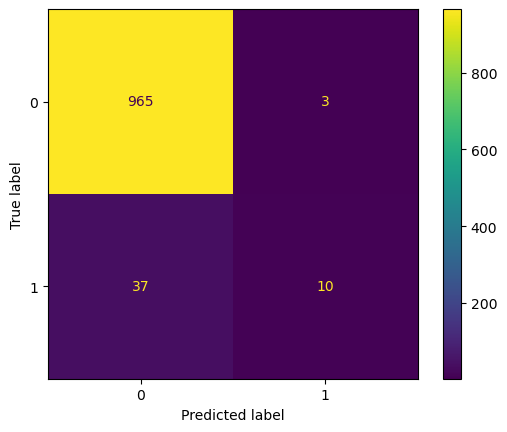

In [71]:
cm=ConfusionMatrixDisplay(confusion_matrix(test_y, y_pred2))
cm.plot()
plt.show()

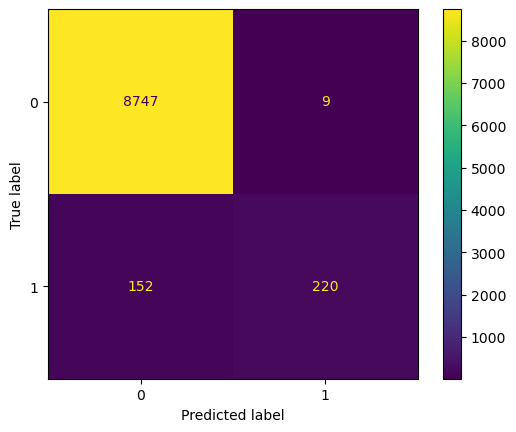

In [72]:
cm=ConfusionMatrixDisplay(confusion_matrix(train_y, y_pred3))
cm.plot()
plt.show()

In [73]:
false_positive_rate, true_positive_rate, threshold1 = roc_curve(test_y, y_pred2)
'Test roc='+str(roc_auc_score(test_y, y_pred2))

'Test roc=0.6048333919465448'

In [74]:
false_positive_rate, true_positive_rate, threshold1 = roc_curve(train_y, y_pred3)
'Train roc='+str(roc_auc_score(train_y, y_pred3))

'Train roc=0.7951849914283048'

In [75]:
mae = mean_absolute_error(test_y, y_pred2)
mse = mean_squared_error(test_y, y_pred2)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = r2_score(test_y, y_pred2)

print("----Test-------")
print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

----Test-------
Results of sklearn.metrics:
MAE: 0.03940886699507389
MSE: 0.03940886699507389
RMSE: 0.19851666679418606
R-Squared: 0.1076138561631792


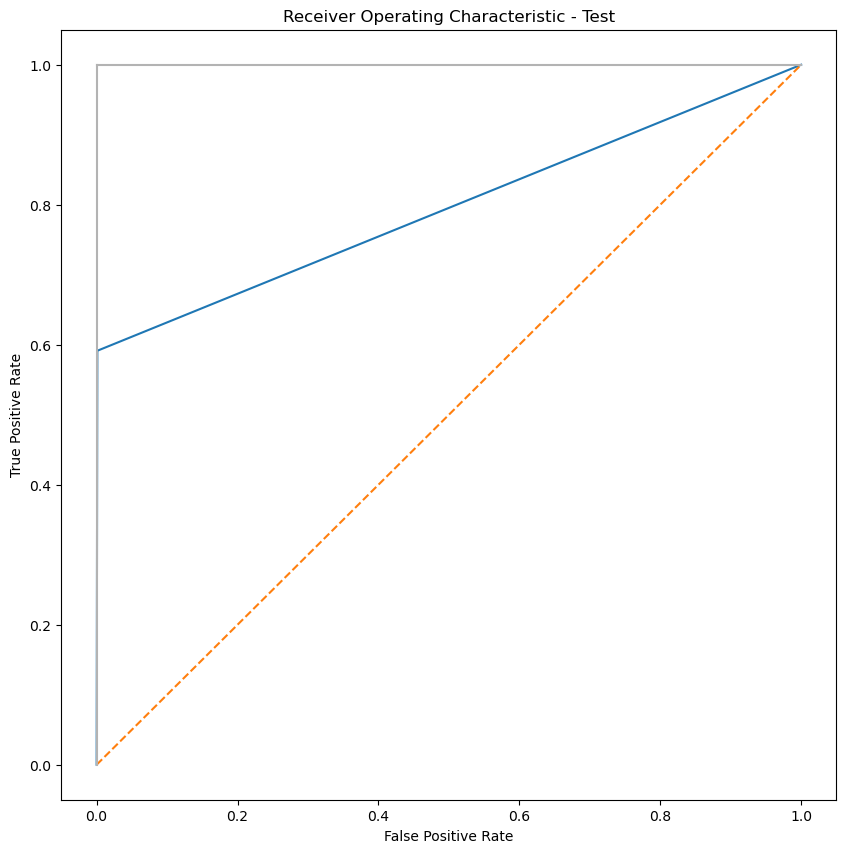

In [76]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Test')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [77]:
mae = mean_absolute_error(train_y, y_pred3)
mse = mean_squared_error(train_y, y_pred3)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = r2_score(train_y, y_pred3)

print("----Train-------")
print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

----Train-------
Results of sklearn.metrics:
MAE: 0.01763803680981595
MSE: 0.01763803680981595
RMSE: 0.1328082708637378
R-Squared: 0.5488169095722993


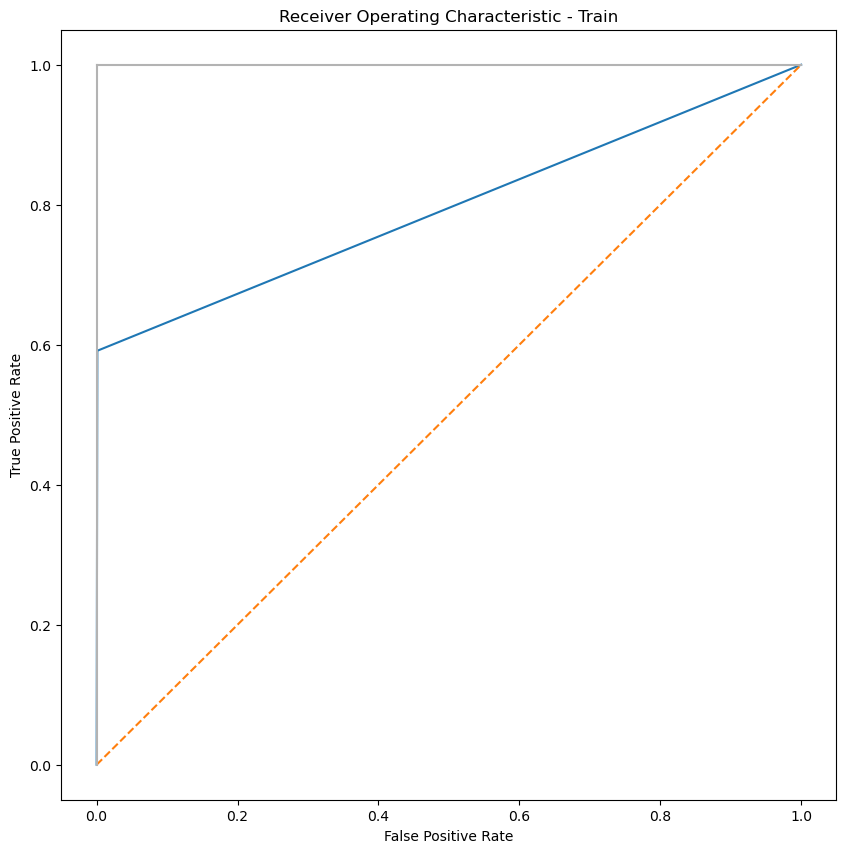

In [78]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Train')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### -- The End